In [1]:
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

from utility import *
from model_utility import *

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
LOOKBACK = 61
TRAIN_SPLIT_RATIO = 0.9
columns = [OPEN_INDEX, HIGH_INDEX, LOW_INDEX, CLOSE_INDEX, VOLUME_INDEX]

LAST_MONTH_NUM_RECORDS = 2880

In [4]:
todays_date = datetime.now().strftime('%Y-%m-%d')
download_monthly_klines('spot', [BTC], ['15m'], '2019-01-01', todays_date, 'train')

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-01.zip
[##################################################]
File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-02.zip
[##################################################]
File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-03.zip
[##################################################]
File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-04.zip
[##################################################]
File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-05.zip
[##################################################]
File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-06.zip
[##################################################]
File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-07.zip
[##################################################]
File Download: /content/train/BTCUSDT/BTCUSDT-15m-2019-08.zip
[##################################################]
File Download: /

In [5]:
dataframe = get_data('train', BTC)

train/BTCUSDT/BTCUSDT-15m-2019-01.csv
train/BTCUSDT/BTCUSDT-15m-2019-02.csv
train/BTCUSDT/BTCUSDT-15m-2019-03.csv
train/BTCUSDT/BTCUSDT-15m-2019-04.csv
train/BTCUSDT/BTCUSDT-15m-2019-05.csv
train/BTCUSDT/BTCUSDT-15m-2019-06.csv
train/BTCUSDT/BTCUSDT-15m-2019-07.csv
train/BTCUSDT/BTCUSDT-15m-2019-08.csv
train/BTCUSDT/BTCUSDT-15m-2019-09.csv
train/BTCUSDT/BTCUSDT-15m-2019-10.csv
train/BTCUSDT/BTCUSDT-15m-2019-11.csv
train/BTCUSDT/BTCUSDT-15m-2019-12.csv
train/BTCUSDT/BTCUSDT-15m-2020-01.csv
train/BTCUSDT/BTCUSDT-15m-2020-02.csv
train/BTCUSDT/BTCUSDT-15m-2020-03.csv
train/BTCUSDT/BTCUSDT-15m-2020-04.csv
train/BTCUSDT/BTCUSDT-15m-2020-05.csv
train/BTCUSDT/BTCUSDT-15m-2020-06.csv
train/BTCUSDT/BTCUSDT-15m-2020-07.csv
train/BTCUSDT/BTCUSDT-15m-2020-08.csv
train/BTCUSDT/BTCUSDT-15m-2020-09.csv
train/BTCUSDT/BTCUSDT-15m-2020-10.csv
train/BTCUSDT/BTCUSDT-15m-2020-11.csv
train/BTCUSDT/BTCUSDT-15m-2020-12.csv
train/BTCUSDT/BTCUSDT-15m-2021-01.csv
train/BTCUSDT/BTCUSDT-15m-2021-02.csv
train/BTCUSD

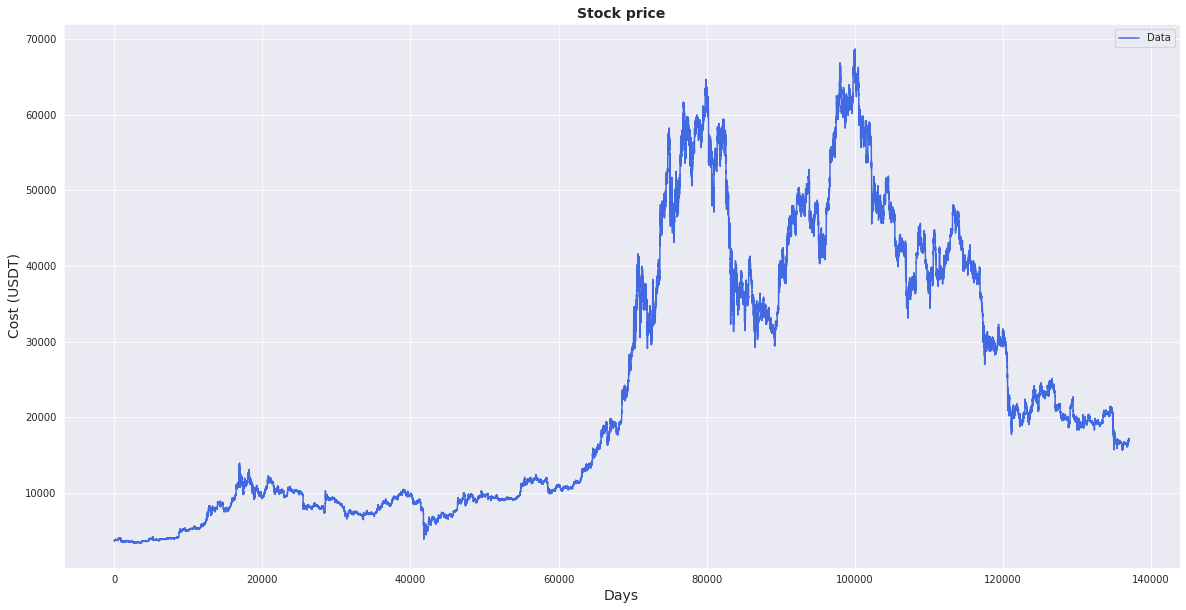

In [6]:
dataframe = dataframe[dataframe[IGNORE_INDEX] == 0]
plot_graph(pd.DataFrame(dataframe[CLOSE_INDEX].values))

In [7]:
scalers = {}
for col in columns:
    scaler = MinMaxScaler().fit(dataframe[[col]])
    dataframe[col] = scaler.transform(dataframe[[col]])
    scalers[col] = scaler

dataframe = dataframe[columns]

In [8]:
x_train, y_train, x_test, y_test = split_data(dataframe, LOOKBACK, TRAIN_SPLIT_RATIO, CLOSE_INDEX-1)

print('x_train.shape = {}'.format(x_train.shape))
print('y_train.shape = {}'.format(y_train.shape))
print('x_test.shape = {}'.format(x_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

x_train.shape = (123260, 60, 5)
y_train.shape = (123260,)
x_test.shape = (13695, 60, 5)
y_test.shape = (13695,)


In [9]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [10]:
input_dim = x_train.shape[1]
n_features = x_train.shape[2]
output_dim = 1

batch_size = 1000

In [11]:
cnn_lstm = tf.keras.Sequential()

cnn_lstm.add(tf.keras.layers.Conv1D(128, 3, activation='relu', input_shape=(60, 5)))
cnn_lstm.add(tf.keras.layers.Conv1D(256, 3, activation='relu'))
cnn_lstm.add(tf.keras.layers.LSTM(64, return_sequences=True))
cnn_lstm.add(tf.keras.layers.LSTM(128))
cnn_lstm.add(tf.keras.layers.Dense(1))

cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 128)           2048      
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 256)           98560     
                                                                 
 lstm (LSTM)                 (None, 56, 64)            82176     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 281,729
Trainable params: 281,729
Non-trainable params: 0
_________________________________________________________________


In [12]:
cnn_lstm.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [13]:
hist = cnn_lstm.fit(x_train, y_train, epochs=20)

Epoch 1/20
3852/3852 [==============================] - 44s 9ms/step - loss: 0.0066 - root_mean_squared_error: 0.0134
Epoch 2/20
3852/3852 [==============================] - 33s 8ms/step - loss: 0.0041 - root_mean_squared_error: 0.0068
Epoch 3/20
3852/3852 [==============================] - 33s 9ms/step - loss: 0.0033 - root_mean_squared_error: 0.0053
Epoch 4/20
3852/3852 [==============================] - 32s 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0047
Epoch 5/20
3852/3852 [==============================] - 32s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0045
Epoch 6/20
3852/3852 [==============================] - 32s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0039
Epoch 7/20
3852/3852 [==============================] - 32s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0039
Epoch 8/20
3852/3852 [==============================] - 32s 8ms/step - loss: 0.0021 - root_mean_squared_error: 0.0034
Epoch 9/20
3852/3852 [==============================] - 

In [14]:
cnn_lstm.evaluate(x_test, y_test)

428/428 [==============================] - 3s 5ms/step - loss: 6.9061e-04 - root_mean_squared_error: 0.0011


[0.0006906133494339883, 0.0010840691393241286]

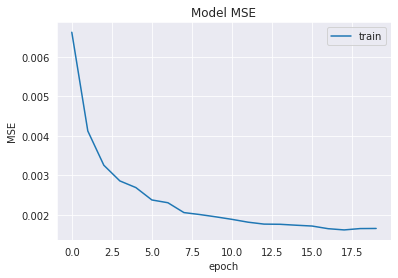

In [15]:
plt.plot(hist.history['loss'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()

In [16]:
y_train_pred = cnn_lstm.predict(x_train)

3852/3852 [==============================] - 15s 4ms/step


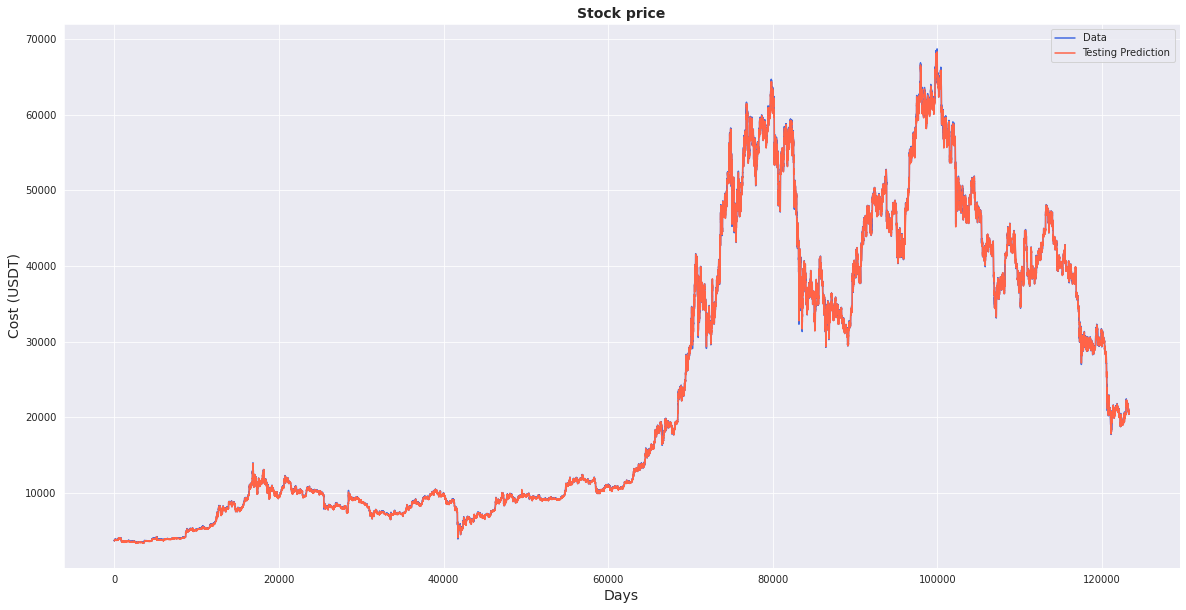

In [17]:
plot_graph(pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_train.numpy().reshape(-1, 1))), 
           pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_train_pred.reshape(-1, 1))))

In [18]:
y_test_pred = cnn_lstm.predict(x_test)

428/428 [==============================] - 2s 4ms/step


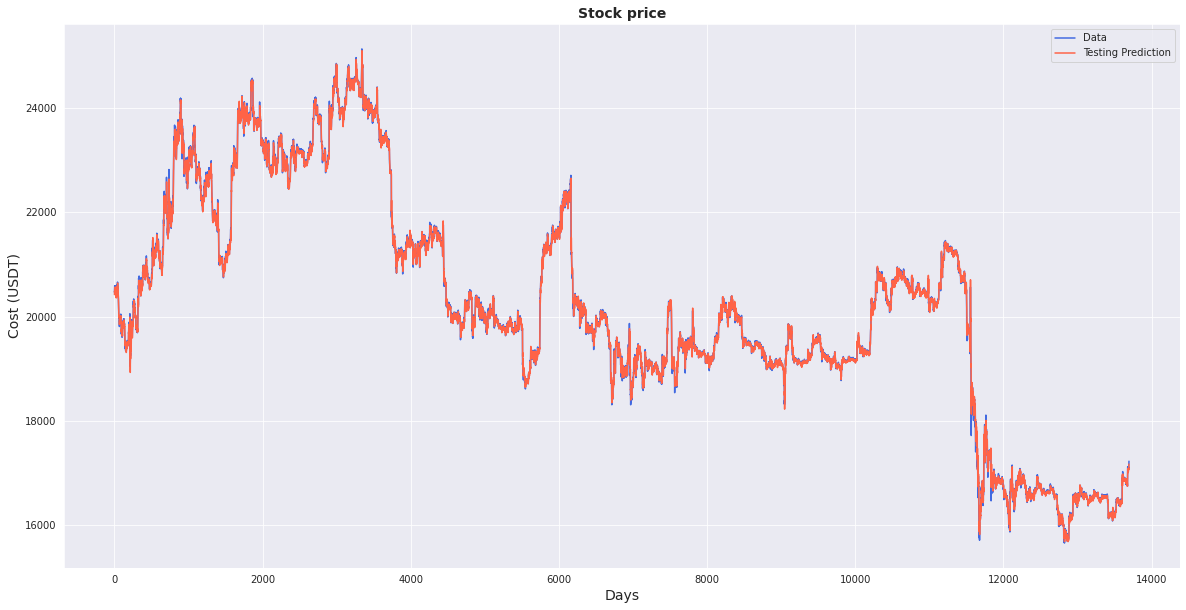

In [19]:
plot_graph(pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_test.numpy().reshape(-1, 1))), 
           pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_test_pred.reshape(-1, 1))))

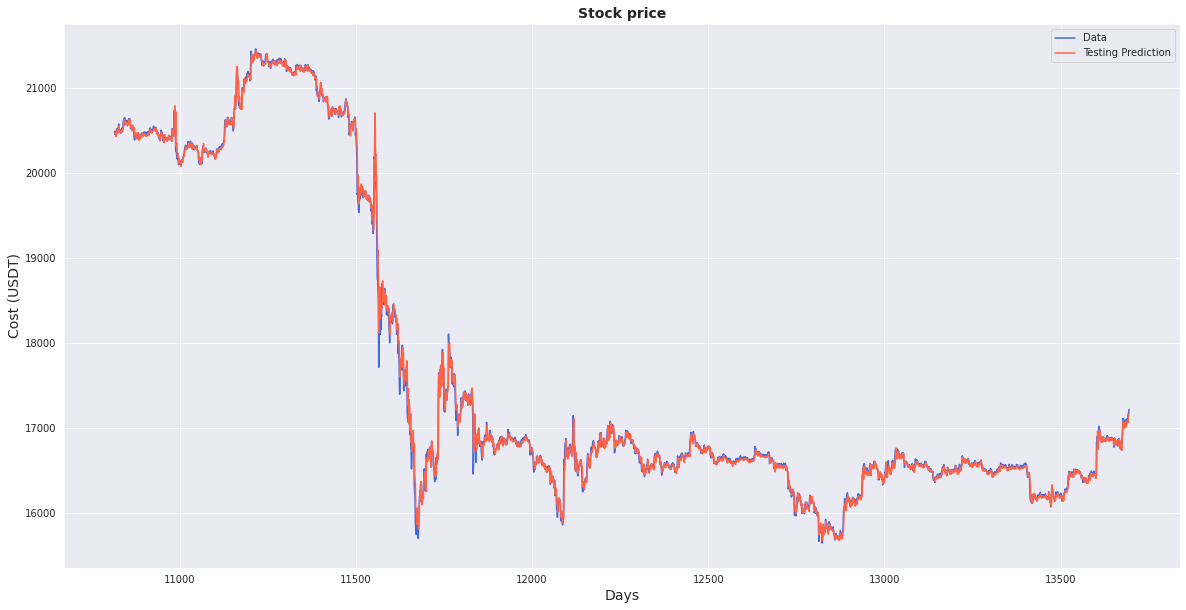

In [20]:
plot_graph(pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_test.numpy().reshape(-1, 1)))[-LAST_MONTH_NUM_RECORDS:], 
           pd.DataFrame(scalers[CLOSE_INDEX].inverse_transform(y_test_pred.reshape(-1, 1)))[-LAST_MONTH_NUM_RECORDS:])